In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
train_dir = '../../fruits-360/Training/'
test_dir = '../../fruits-360/Test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [3]:
classes = os.listdir(train_dir)
print(classes)
print(len(classes))

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

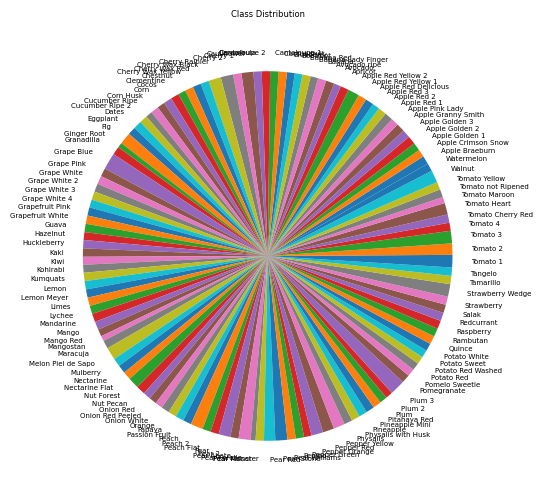

In [4]:
# Assuming you have a list of class labels in 'classes' and train_labels as the data
# Calculate the counts for each class
class_counts = [len([x for x in train_labels if x == label]) for label in classes]

# Set the figure size and font size
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 5})

# Create the pie chart
plt.pie(class_counts, labels=classes, startangle=30)

# Add a title
plt.title('Class Distribution')

# Display the chart
plt.show()


In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

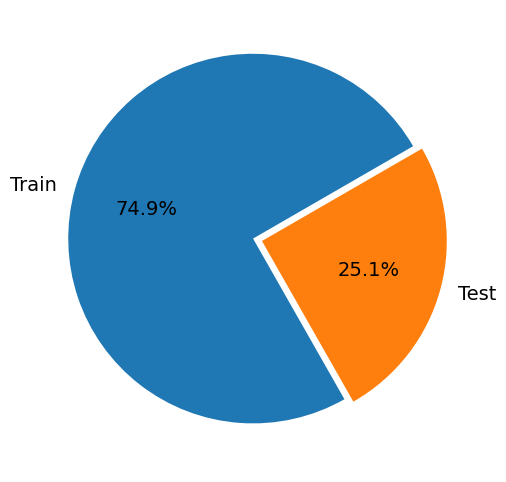

In [6]:
plt.figure(figsize=(14,6))
#colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

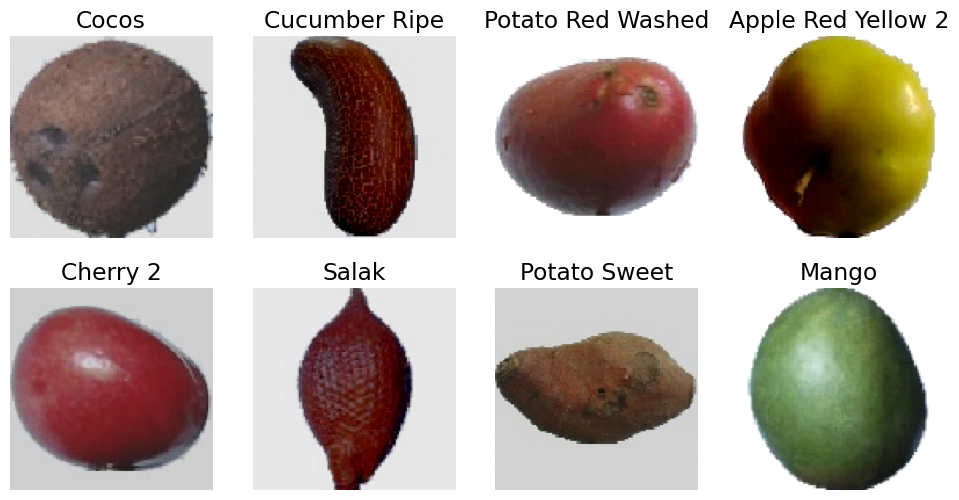

In [8]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [10]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 131)               16899     
                                                                 
Total params: 15,780,291
Trainable params: 8,145,027
Non

In [12]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [14]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
  21/3384 [..............................] - ETA: 1:47:40 - loss: 4.9548 - sparse_categorical_accuracy: 0.01903384/3384 [==============================] - 6727s 2s/step - loss: 0.5428 - sparse_categorical_accuracy: 0.8715
Epoch 2/10
3384/3384 [==============================] - 6558s 2s/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9871
Epoch 3/10
3384/3384 [==============================] - 6143s 2s/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9915
Epoch 4/10
3384/3384 [==============================] - 5650s 2s/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9948
Epoch 6/10
3384/3384 [==============================] - 10167s 3s/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9949
Epoch 7/10
3384/3384 [==============================] - 7321s 2s/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9961
Epoch 8/10
3384/3384 [==============================] - 10758s 3s/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9964
Epoch 9/10
3384/3384 [=====

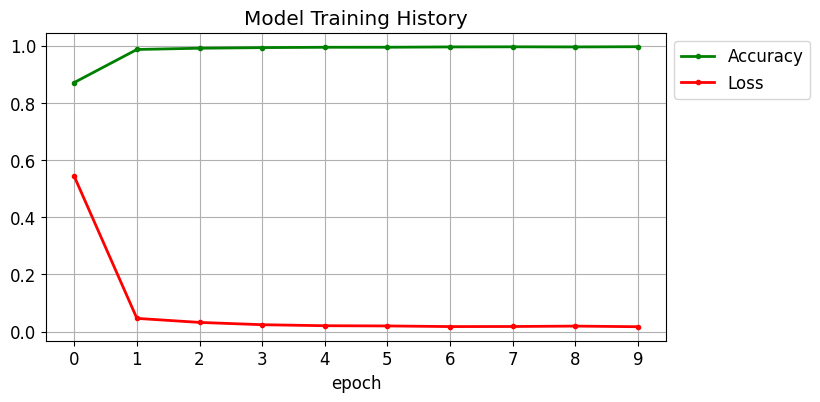

In [15]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [16]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                                                                       | 0/709 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|▏                                                                                                                              | 1/709 [00:02<31:42,  2.69s/it]

1/1 [==============================] - 1s 1s/step


  0%|▎                                                                                                                              | 2/709 [00:04<24:18,  2.06s/it]

1/1 [==============================] - 1s 1s/step


  0%|▌                                                                                                                              | 3/709 [00:05<21:11,  1.80s/it]

1/1 [==============================] - 1s 1s/step


  1%|▋                                                                                                                              | 4/709 [00:07<19:53,  1.69s/it]

1/1 [==============================] - 1s 1s/step


  1%|▉                                                                                                                              | 5/709 [00:08<17:41,  1.51s/it]

1/1 [==============================] - 1s 1s/step


  1%|█                                                                                                                              | 6/709 [00:09<16:21,  1.40s/it]

1/1 [==============================] - 1s 1s/step


  1%|█▎                                                                                                                             | 7/709 [00:10<15:27,  1.32s/it]

1/1 [==============================] - 1s 1s/step


  1%|█▍                                                                                                                             | 8/709 [00:12<14:48,  1.27s/it]

1/1 [==============================] - 1s 1s/step


  1%|█▌                                                                                                                             | 9/709 [00:13<14:29,  1.24s/it]

1/1 [==============================] - 1s 1s/step


  1%|█▊                                                                                                                            | 10/709 [00:14<14:15,  1.22s/it]

1/1 [==============================] - 1s 1s/step


  2%|█▉                                                                                                                            | 11/709 [00:15<14:05,  1.21s/it]

1/1 [==============================] - 1s 1s/step


  2%|██▏                                                                                                                           | 12/709 [00:16<13:54,  1.20s/it]

1/1 [==============================] - 1s 1s/step


  2%|██▎                                                                                                                           | 13/709 [00:17<13:56,  1.20s/it]

1/1 [==============================] - 1s 1s/step


  2%|██▍                                                                                                                           | 14/709 [00:22<24:16,  2.10s/it]

1/1 [==============================] - 1s 1s/step


  2%|██▋                                                                                                                           | 15/709 [00:23<21:03,  1.82s/it]

1/1 [==============================] - 1s 1s/step


  2%|██▊                                                                                                                           | 16/709 [00:24<19:11,  1.66s/it]

1/1 [==============================] - 1s 1s/step


  2%|███                                                                                                                           | 17/709 [00:25<17:28,  1.51s/it]

1/1 [==============================] - 1s 1s/step


  3%|███▏                                                                                                                          | 18/709 [00:26<16:15,  1.41s/it]

1/1 [==============================] - 1s 1s/step


  3%|███▍                                                                                                                          | 19/709 [00:28<15:24,  1.34s/it]

1/1 [==============================] - 1s 1s/step


  3%|███▌                                                                                                                          | 20/709 [00:29<14:51,  1.29s/it]

1/1 [==============================] - 1s 1s/step


  3%|███▋                                                                                                                          | 21/709 [00:30<14:25,  1.26s/it]

1/1 [==============================] - 1s 1s/step


  3%|███▉                                                                                                                          | 22/709 [00:31<14:06,  1.23s/it]

1/1 [==============================] - 1s 1s/step


  3%|████                                                                                                                          | 23/709 [00:32<14:03,  1.23s/it]

1/1 [==============================] - 2s 2s/step


  3%|████▎                                                                                                                         | 24/709 [00:34<16:15,  1.42s/it]

1/1 [==============================] - 1s 1s/step


  4%|████▍                                                                                                                         | 25/709 [00:36<16:05,  1.41s/it]

1/1 [==============================] - 1s 1s/step


  4%|████▌                                                                                                                         | 26/709 [00:37<16:04,  1.41s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▊                                                                                                                         | 27/709 [00:39<17:39,  1.55s/it]

1/1 [==============================] - 2s 2s/step


  4%|████▉                                                                                                                         | 28/709 [00:41<19:48,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  4%|█████▏                                                                                                                        | 29/709 [00:43<19:55,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|█████▎                                                                                                                        | 30/709 [00:45<19:56,  1.76s/it]

1/1 [==============================] - 2s 2s/step


  4%|█████▌                                                                                                                        | 31/709 [00:47<20:17,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▋                                                                                                                        | 32/709 [00:48<19:55,  1.77s/it]

1/1 [==============================] - 2s 2s/step


  5%|█████▊                                                                                                                        | 33/709 [00:50<19:42,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  5%|██████                                                                                                                        | 34/709 [00:52<19:45,  1.76s/it]

1/1 [==============================] - 1s 1s/step


  5%|██████▏                                                                                                                       | 35/709 [00:53<19:00,  1.69s/it]

1/1 [==============================] - 1s 1s/step


  5%|██████▍                                                                                                                       | 36/709 [00:56<21:22,  1.91s/it]

1/1 [==============================] - 4s 4s/step


  5%|██████▌                                                                                                                       | 37/709 [01:00<29:05,  2.60s/it]

1/1 [==============================] - 1s 1s/step


  5%|██████▊                                                                                                                       | 38/709 [01:03<29:56,  2.68s/it]

1/1 [==============================] - 2s 2s/step


  6%|██████▉                                                                                                                       | 39/709 [01:04<26:30,  2.37s/it]

1/1 [==============================] - 1s 1s/step


  6%|███████                                                                                                                       | 40/709 [01:06<23:49,  2.14s/it]

1/1 [==============================] - 5s 5s/step


  6%|███████▎                                                                                                                      | 41/709 [01:11<33:20,  2.99s/it]

1/1 [==============================] - 2s 2s/step


  6%|███████▍                                                                                                                      | 42/709 [01:13<31:13,  2.81s/it]

1/1 [==============================] - 1s 1s/step


  6%|███████▋                                                                                                                      | 43/709 [01:15<27:15,  2.46s/it]

1/1 [==============================] - 1s 1s/step


  6%|███████▊                                                                                                                      | 44/709 [01:16<23:59,  2.16s/it]

1/1 [==============================] - 2s 2s/step


  6%|███████▉                                                                                                                      | 45/709 [01:18<22:18,  2.02s/it]

1/1 [==============================] - 2s 2s/step


  6%|████████▏                                                                                                                     | 46/709 [01:20<22:21,  2.02s/it]

1/1 [==============================] - 2s 2s/step


  7%|████████▎                                                                                                                     | 47/709 [01:22<21:35,  1.96s/it]

1/1 [==============================] - 2s 2s/step


  7%|████████▌                                                                                                                     | 48/709 [01:24<20:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


  7%|████████▋                                                                                                                     | 49/709 [01:25<20:22,  1.85s/it]

1/1 [==============================] - 1s 1s/step


  7%|████████▉                                                                                                                     | 50/709 [01:27<19:13,  1.75s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████████                                                                                                                     | 51/709 [01:29<18:52,  1.72s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████████▏                                                                                                                    | 52/709 [01:30<19:13,  1.76s/it]

1/1 [==============================] - 1s 1s/step


  7%|█████████▍                                                                                                                    | 53/709 [01:32<18:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  8%|█████████▌                                                                                                                    | 54/709 [01:34<18:51,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  8%|█████████▊                                                                                                                    | 55/709 [01:36<19:09,  1.76s/it]

1/1 [==============================] - 1s 1s/step


  8%|█████████▉                                                                                                                    | 56/709 [01:37<18:39,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████████▏                                                                                                                   | 57/709 [01:39<18:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████████▎                                                                                                                   | 58/709 [01:41<19:32,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████████▍                                                                                                                   | 59/709 [01:43<19:29,  1.80s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████████▋                                                                                                                   | 60/709 [01:45<21:05,  1.95s/it]

1/1 [==============================] - 2s 2s/step


  9%|██████████▊                                                                                                                   | 61/709 [01:47<20:19,  1.88s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████████                                                                                                                   | 62/709 [01:48<19:32,  1.81s/it]

1/1 [==============================] - 2s 2s/step


  9%|███████████▏                                                                                                                  | 63/709 [01:50<19:30,  1.81s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████████▎                                                                                                                  | 64/709 [01:52<18:41,  1.74s/it]

1/1 [==============================] - 1s 1s/step


  9%|███████████▌                                                                                                                  | 65/709 [01:54<18:22,  1.71s/it]

1/1 [==============================] - 2s 2s/step


  9%|███████████▋                                                                                                                  | 66/709 [01:55<18:35,  1.73s/it]

1/1 [==============================] - 2s 2s/step


  9%|███████████▉                                                                                                                  | 67/709 [01:57<18:50,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████                                                                                                                  | 68/709 [01:59<18:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▎                                                                                                                 | 69/709 [02:01<19:03,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▍                                                                                                                 | 70/709 [02:03<18:55,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▌                                                                                                                 | 71/709 [02:05<20:16,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▊                                                                                                                 | 72/709 [02:08<23:48,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████████▉                                                                                                                 | 73/709 [02:10<23:56,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 10%|█████████████▏                                                                                                                | 74/709 [02:12<24:18,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 11%|█████████████▎                                                                                                                | 75/709 [02:14<23:31,  2.23s/it]

1/1 [==============================] - 2s 2s/step


 11%|█████████████▌                                                                                                                | 76/709 [02:17<23:08,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 11%|█████████████▋                                                                                                                | 77/709 [02:18<21:48,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 11%|█████████████▊                                                                                                                | 78/709 [02:20<20:04,  1.91s/it]

1/1 [==============================] - 6s 6s/step


 11%|██████████████                                                                                                                | 79/709 [02:26<32:09,  3.06s/it]

1/1 [==============================] - 5s 5s/step


 11%|██████████████▏                                                                                                               | 80/709 [02:30<37:27,  3.57s/it]

1/1 [==============================] - 2s 2s/step


 11%|██████████████▍                                                                                                               | 81/709 [02:32<32:13,  3.08s/it]

1/1 [==============================] - 1s 1s/step


 12%|██████████████▌                                                                                                               | 82/709 [02:34<27:47,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 12%|██████████████▊                                                                                                               | 83/709 [02:36<25:35,  2.45s/it]

1/1 [==============================] - 1s 1s/step


 12%|██████████████▉                                                                                                               | 84/709 [02:38<23:00,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 12%|███████████████                                                                                                               | 85/709 [02:40<22:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 12%|███████████████▎                                                                                                              | 86/709 [02:41<20:56,  2.02s/it]

1/1 [==============================] - 1s 1s/step


 12%|███████████████▍                                                                                                              | 87/709 [02:43<19:48,  1.91s/it]

1/1 [==============================] - 1s 1s/step


 12%|███████████████▋                                                                                                              | 88/709 [02:45<18:46,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 13%|███████████████▊                                                                                                              | 89/709 [02:46<18:06,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 13%|███████████████▉                                                                                                              | 90/709 [02:48<18:15,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 13%|████████████████▏                                                                                                             | 91/709 [02:50<17:44,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 13%|████████████████▎                                                                                                             | 92/709 [02:51<17:15,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 13%|████████████████▌                                                                                                             | 93/709 [02:53<17:11,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 13%|████████████████▋                                                                                                             | 94/709 [02:54<16:55,  1.65s/it]

1/1 [==============================] - 1s 1s/step


 13%|████████████████▉                                                                                                             | 95/709 [02:56<16:40,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████                                                                                                             | 96/709 [02:58<16:39,  1.63s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▏                                                                                                            | 97/709 [02:59<16:29,  1.62s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▍                                                                                                            | 98/709 [03:02<20:09,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▌                                                                                                            | 99/709 [03:04<18:52,  1.86s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▋                                                                                                           | 100/709 [03:05<17:56,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▊                                                                                                           | 101/709 [03:07<17:38,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 14%|█████████████████▉                                                                                                           | 102/709 [03:09<17:17,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 15%|██████████████████▏                                                                                                          | 103/709 [03:10<16:53,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 15%|██████████████████▎                                                                                                          | 104/709 [03:12<16:43,  1.66s/it]

1/1 [==============================] - 2s 2s/step


 15%|██████████████████▌                                                                                                          | 105/709 [03:13<16:47,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 15%|██████████████████▋                                                                                                          | 106/709 [03:15<16:34,  1.65s/it]

1/1 [==============================] - 2s 2s/step


 15%|██████████████████▊                                                                                                          | 107/709 [03:17<16:43,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████████                                                                                                          | 108/709 [03:19<17:36,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|███████████████████▏                                                                                                         | 109/709 [03:21<17:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 16%|███████████████████▍                                                                                                         | 110/709 [03:22<18:05,  1.81s/it]

1/1 [==============================] - 1s 1s/step


 16%|███████████████████▌                                                                                                         | 111/709 [03:24<17:26,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 16%|███████████████████▋                                                                                                         | 112/709 [03:26<17:11,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 16%|███████████████████▉                                                                                                         | 113/709 [03:27<17:06,  1.72s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████████████                                                                                                         | 114/709 [03:29<16:47,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████████████▎                                                                                                        | 115/709 [03:31<16:40,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 16%|████████████████████▍                                                                                                        | 116/709 [03:32<16:39,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 17%|████████████████████▋                                                                                                        | 117/709 [03:34<16:38,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 17%|████████████████████▊                                                                                                        | 118/709 [03:36<16:35,  1.68s/it]

1/1 [==============================] - 1s 1s/step


 17%|████████████████████▉                                                                                                        | 119/709 [03:37<16:18,  1.66s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████████████▏                                                                                                       | 120/709 [03:39<16:22,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████████████▎                                                                                                       | 121/709 [03:44<25:10,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 17%|█████████████████████▌                                                                                                       | 122/709 [03:46<22:47,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████████████▋                                                                                                       | 123/709 [03:47<20:50,  2.13s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████████████▊                                                                                                       | 124/709 [03:49<19:37,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████████                                                                                                       | 125/709 [03:51<18:40,  1.92s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████████████▏                                                                                                      | 126/709 [03:52<17:51,  1.84s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████████████▍                                                                                                      | 127/709 [03:54<17:21,  1.79s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████████████▌                                                                                                      | 128/709 [03:56<16:57,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████████▋                                                                                                      | 129/709 [03:57<17:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████████████▉                                                                                                      | 130/709 [03:59<17:07,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 18%|███████████████████████                                                                                                      | 131/709 [04:01<17:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████████▎                                                                                                     | 132/709 [04:03<18:53,  1.96s/it]

1/1 [==============================] - 8s 8s/step


 19%|███████████████████████▍                                                                                                     | 133/709 [04:12<38:10,  3.98s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████████▌                                                                                                     | 134/709 [04:14<33:04,  3.45s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████████▊                                                                                                     | 135/709 [04:16<28:46,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 19%|███████████████████████▉                                                                                                     | 136/709 [04:18<26:08,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████████▏                                                                                                    | 137/709 [04:21<24:52,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 19%|████████████████████████▎                                                                                                    | 138/709 [04:23<23:39,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████████▌                                                                                                    | 139/709 [04:25<22:38,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████████▋                                                                                                    | 140/709 [04:27<22:05,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████████████▊                                                                                                    | 141/709 [04:30<21:44,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████████                                                                                                    | 142/709 [04:32<20:54,  2.21s/it]

1/1 [==============================] - 4s 4s/step


 20%|█████████████████████████▏                                                                                                   | 143/709 [04:36<27:04,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 20%|█████████████████████████▍                                                                                                   | 144/709 [04:40<29:30,  3.13s/it]

1/1 [==============================] - 2s 2s/step


 20%|█████████████████████████▌                                                                                                   | 145/709 [04:42<27:50,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████████▋                                                                                                   | 146/709 [04:44<25:45,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 21%|█████████████████████████▉                                                                                                   | 147/709 [04:47<23:43,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████████                                                                                                   | 148/709 [04:48<22:05,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████████▎                                                                                                  | 149/709 [04:50<20:54,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████████▍                                                                                                  | 150/709 [04:53<20:26,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████████▌                                                                                                  | 151/709 [04:54<19:40,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 21%|██████████████████████████▊                                                                                                  | 152/709 [04:57<19:51,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████████████▉                                                                                                  | 153/709 [04:59<19:41,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████████▏                                                                                                 | 154/709 [05:01<21:08,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████████▎                                                                                                 | 155/709 [05:03<20:26,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████████▌                                                                                                 | 156/709 [05:05<19:45,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████████▋                                                                                                 | 157/709 [05:07<19:20,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 22%|███████████████████████████▊                                                                                                 | 158/709 [05:09<18:37,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 22%|████████████████████████████                                                                                                 | 159/709 [05:11<18:20,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████████▏                                                                                                | 160/709 [05:13<18:09,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████████▍                                                                                                | 161/709 [05:15<18:31,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████████▌                                                                                                | 162/709 [05:17<18:28,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████████▋                                                                                                | 163/709 [05:19<18:13,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 23%|████████████████████████████▉                                                                                                | 164/709 [05:21<17:40,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 23%|█████████████████████████████                                                                                                | 165/709 [05:23<17:12,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 23%|█████████████████████████████▎                                                                                               | 166/709 [05:25<17:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████████▍                                                                                               | 167/709 [05:27<17:17,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████████▌                                                                                               | 168/709 [05:29<17:01,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████████▊                                                                                               | 169/709 [05:30<16:42,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 24%|█████████████████████████████▉                                                                                               | 170/709 [05:32<16:39,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 24%|██████████████████████████████▏                                                                                              | 171/709 [05:34<16:37,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 24%|██████████████████████████████▎                                                                                              | 172/709 [05:36<16:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 24%|██████████████████████████████▌                                                                                              | 173/709 [05:38<16:15,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████████▋                                                                                              | 174/709 [05:39<16:10,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 25%|██████████████████████████████▊                                                                                              | 175/709 [05:41<15:58,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████                                                                                              | 176/709 [05:43<15:55,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████▏                                                                                             | 177/709 [05:45<15:58,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████▍                                                                                             | 178/709 [05:47<16:15,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████▌                                                                                             | 179/709 [05:48<16:03,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 25%|███████████████████████████████▋                                                                                             | 180/709 [05:50<16:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 26%|███████████████████████████████▉                                                                                             | 181/709 [05:53<17:03,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████                                                                                             | 182/709 [05:55<17:21,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████▎                                                                                            | 183/709 [05:57<17:34,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████▍                                                                                            | 184/709 [05:59<17:08,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████▌                                                                                            | 185/709 [06:00<16:31,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████▊                                                                                            | 186/709 [06:02<16:13,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████████████████▉                                                                                            | 187/709 [06:04<16:08,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████████████████▏                                                                                           | 188/709 [06:06<16:20,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████████████████▎                                                                                           | 189/709 [06:08<16:25,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████████████████▍                                                                                           | 190/709 [06:10<16:18,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████████████████▋                                                                                           | 191/709 [06:12<16:31,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████████████████▊                                                                                           | 192/709 [06:13<16:16,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 27%|██████████████████████████████████                                                                                           | 193/709 [06:15<16:24,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 27%|██████████████████████████████████▏                                                                                          | 194/709 [06:17<16:28,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████████████████▍                                                                                          | 195/709 [06:19<16:58,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████████████████▌                                                                                          | 196/709 [06:21<17:05,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████████████████▋                                                                                          | 197/709 [06:23<16:59,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████████████████▉                                                                                          | 198/709 [06:25<16:51,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 28%|███████████████████████████████████                                                                                          | 199/709 [06:27<16:52,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 28%|███████████████████████████████████▎                                                                                         | 200/709 [06:29<16:35,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 28%|███████████████████████████████████▍                                                                                         | 201/709 [06:31<16:14,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 28%|███████████████████████████████████▌                                                                                         | 202/709 [06:33<15:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 29%|███████████████████████████████████▊                                                                                         | 203/709 [06:35<15:49,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 29%|███████████████████████████████████▉                                                                                         | 204/709 [06:37<15:59,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 29%|████████████████████████████████████▏                                                                                        | 205/709 [06:39<15:50,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 29%|████████████████████████████████████▎                                                                                        | 206/709 [06:40<15:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 29%|████████████████████████████████████▍                                                                                        | 207/709 [06:42<15:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 29%|████████████████████████████████████▋                                                                                        | 208/709 [06:44<15:34,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 29%|████████████████████████████████████▊                                                                                        | 209/709 [06:46<15:35,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████                                                                                        | 210/709 [06:48<15:41,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████▏                                                                                       | 211/709 [06:50<15:25,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████▍                                                                                       | 212/709 [06:52<15:27,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████▌                                                                                       | 213/709 [06:53<15:13,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████▋                                                                                       | 214/709 [06:55<15:02,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 30%|█████████████████████████████████████▉                                                                                       | 215/709 [06:57<14:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 30%|██████████████████████████████████████                                                                                       | 216/709 [06:59<14:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|██████████████████████████████████████▎                                                                                      | 217/709 [07:00<14:19,  1.75s/it]

1/1 [==============================] - 1s 1s/step


 31%|██████████████████████████████████████▍                                                                                      | 218/709 [07:02<14:09,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|██████████████████████████████████████▌                                                                                      | 219/709 [07:04<14:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 31%|██████████████████████████████████████▊                                                                                      | 220/709 [07:06<14:24,  1.77s/it]

1/1 [==============================] - 1s 1s/step


 31%|██████████████████████████████████████▉                                                                                      | 221/709 [07:07<14:05,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███████████████████████████████████████▏                                                                                     | 222/709 [07:09<14:07,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 31%|███████████████████████████████████████▎                                                                                     | 223/709 [07:11<13:54,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|███████████████████████████████████████▍                                                                                     | 224/709 [07:12<13:45,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 32%|███████████████████████████████████████▋                                                                                     | 225/709 [07:14<13:47,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|███████████████████████████████████████▊                                                                                     | 226/709 [07:16<13:52,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 32%|████████████████████████████████████████                                                                                     | 227/709 [07:18<13:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 32%|████████████████████████████████████████▏                                                                                    | 228/709 [07:19<13:56,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 32%|████████████████████████████████████████▎                                                                                    | 229/709 [07:21<13:40,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 32%|████████████████████████████████████████▌                                                                                    | 230/709 [07:23<13:45,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|████████████████████████████████████████▋                                                                                    | 231/709 [07:24<13:36,  1.71s/it]

1/1 [==============================] - 1s 1s/step


 33%|████████████████████████████████████████▉                                                                                    | 232/709 [07:26<13:24,  1.69s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████████████████████                                                                                    | 233/709 [07:28<13:14,  1.67s/it]

1/1 [==============================] - 1s 1s/step


 33%|█████████████████████████████████████████▎                                                                                   | 234/709 [07:29<13:11,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 33%|█████████████████████████████████████████▍                                                                                   | 235/709 [07:31<13:37,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|█████████████████████████████████████████▌                                                                                   | 236/709 [07:33<13:31,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 33%|█████████████████████████████████████████▊                                                                                   | 237/709 [07:35<13:34,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 34%|█████████████████████████████████████████▉                                                                                   | 238/709 [07:36<13:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 34%|██████████████████████████████████████████▏                                                                                  | 239/709 [07:38<13:44,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|██████████████████████████████████████████▎                                                                                  | 240/709 [07:40<13:37,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 34%|██████████████████████████████████████████▍                                                                                  | 241/709 [07:42<13:47,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 34%|██████████████████████████████████████████▋                                                                                  | 242/709 [07:43<13:32,  1.74s/it]

1/1 [==============================] - 1s 1s/step


 34%|██████████████████████████████████████████▊                                                                                  | 243/709 [07:45<13:17,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 34%|███████████████████████████████████████████                                                                                  | 244/709 [07:47<13:39,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███████████████████████████████████████████▏                                                                                 | 245/709 [07:49<13:40,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 35%|███████████████████████████████████████████▎                                                                                 | 246/709 [07:50<13:32,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|███████████████████████████████████████████▌                                                                                 | 247/709 [07:52<13:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███████████████████████████████████████████▋                                                                                 | 248/709 [07:54<13:30,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 35%|███████████████████████████████████████████▉                                                                                 | 249/709 [07:56<13:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████████████████████                                                                                 | 250/709 [07:57<13:24,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████████████████████▎                                                                                | 251/709 [07:59<13:19,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|████████████████████████████████████████████▍                                                                                | 252/709 [08:01<13:21,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 36%|████████████████████████████████████████████▌                                                                                | 253/709 [08:03<13:43,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 36%|████████████████████████████████████████████▊                                                                                | 254/709 [08:05<13:38,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|████████████████████████████████████████████▉                                                                                | 255/709 [08:07<13:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████████████▏                                                                               | 256/709 [08:08<13:24,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████████████▎                                                                               | 257/709 [08:10<13:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 36%|█████████████████████████████████████████████▍                                                                               | 258/709 [08:12<13:30,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|█████████████████████████████████████████████▋                                                                               | 259/709 [08:14<13:22,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|█████████████████████████████████████████████▊                                                                               | 260/709 [08:15<13:19,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|██████████████████████████████████████████████                                                                               | 261/709 [08:17<13:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|██████████████████████████████████████████████▏                                                                              | 262/709 [08:19<13:20,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 37%|██████████████████████████████████████████████▎                                                                              | 263/709 [08:21<13:11,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 37%|██████████████████████████████████████████████▌                                                                              | 264/709 [08:23<13:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 37%|██████████████████████████████████████████████▋                                                                              | 265/709 [08:24<13:10,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|██████████████████████████████████████████████▉                                                                              | 266/709 [08:26<13:05,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████                                                                              | 267/709 [08:28<13:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▏                                                                             | 268/709 [08:30<13:04,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▍                                                                             | 269/709 [08:31<13:07,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▌                                                                             | 270/709 [08:33<13:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▊                                                                             | 271/709 [08:35<12:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 38%|███████████████████████████████████████████████▉                                                                             | 272/709 [08:37<13:01,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 39%|████████████████████████████████████████████████▏                                                                            | 273/709 [08:38<12:52,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|████████████████████████████████████████████████▎                                                                            | 274/709 [08:40<12:49,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 39%|████████████████████████████████████████████████▍                                                                            | 275/709 [08:42<12:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|████████████████████████████████████████████████▋                                                                            | 276/709 [08:44<12:52,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 39%|████████████████████████████████████████████████▊                                                                            | 277/709 [08:46<13:03,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 39%|█████████████████████████████████████████████████                                                                            | 278/709 [08:48<13:14,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 39%|█████████████████████████████████████████████████▏                                                                           | 279/709 [08:50<13:16,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 39%|█████████████████████████████████████████████████▎                                                                           | 280/709 [08:51<13:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 40%|█████████████████████████████████████████████████▌                                                                           | 281/709 [08:53<12:53,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|█████████████████████████████████████████████████▋                                                                           | 282/709 [08:55<12:43,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|█████████████████████████████████████████████████▉                                                                           | 283/709 [08:57<12:52,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 40%|██████████████████████████████████████████████████                                                                           | 284/709 [08:58<12:40,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|██████████████████████████████████████████████████▏                                                                          | 285/709 [09:00<12:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 40%|██████████████████████████████████████████████████▍                                                                          | 286/709 [09:02<12:38,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 40%|██████████████████████████████████████████████████▌                                                                          | 287/709 [09:04<12:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|██████████████████████████████████████████████████▊                                                                          | 288/709 [09:06<12:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 41%|██████████████████████████████████████████████████▉                                                                          | 289/709 [09:07<12:25,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████████████████████████▏                                                                         | 290/709 [09:09<12:15,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████████████████████████▎                                                                         | 291/709 [09:11<12:08,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████████████████████████▍                                                                         | 292/709 [09:13<12:52,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████████████████████████▋                                                                         | 293/709 [09:15<13:20,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 41%|███████████████████████████████████████████████████▊                                                                         | 294/709 [09:17<13:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████                                                                         | 295/709 [09:19<13:16,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████▏                                                                        | 296/709 [09:21<14:11,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████▎                                                                        | 297/709 [09:23<14:05,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████▌                                                                        | 298/709 [09:25<14:02,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████▋                                                                        | 299/709 [09:27<13:56,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 42%|████████████████████████████████████████████████████▉                                                                        | 300/709 [09:29<14:14,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 42%|█████████████████████████████████████████████████████                                                                        | 301/709 [09:31<14:01,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████████████████████████████████████████▏                                                                       | 302/709 [09:34<14:03,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████████████████████████████████████████▍                                                                       | 303/709 [09:36<14:04,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████████████████████████████████████████▌                                                                       | 304/709 [09:39<15:59,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████████████████████████████████████████▊                                                                       | 305/709 [09:41<15:12,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 43%|█████████████████████████████████████████████████████▉                                                                       | 306/709 [09:42<14:15,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 43%|██████████████████████████████████████████████████████▏                                                                      | 307/709 [09:44<13:45,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 43%|██████████████████████████████████████████████████████▎                                                                      | 308/709 [09:46<13:16,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 44%|██████████████████████████████████████████████████████▍                                                                      | 309/709 [09:48<12:53,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 44%|██████████████████████████████████████████████████████▋                                                                      | 310/709 [09:50<12:43,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 44%|██████████████████████████████████████████████████████▊                                                                      | 311/709 [09:52<12:25,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 44%|███████████████████████████████████████████████████████                                                                      | 312/709 [09:53<12:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|███████████████████████████████████████████████████████▏                                                                     | 313/709 [09:55<12:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 44%|███████████████████████████████████████████████████████▎                                                                     | 314/709 [09:57<12:21,  1.88s/it]

1/1 [==============================] - 3s 3s/step


 44%|███████████████████████████████████████████████████████▌                                                                     | 315/709 [10:01<15:36,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 45%|███████████████████████████████████████████████████████▋                                                                     | 316/709 [10:03<15:11,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 45%|███████████████████████████████████████████████████████▉                                                                     | 317/709 [10:05<14:44,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████████████████████████                                                                     | 318/709 [10:07<13:59,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████████████████████████▏                                                                    | 319/709 [10:09<13:09,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████████████████████████▍                                                                    | 320/709 [10:11<12:36,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████████████████████████▌                                                                    | 321/709 [10:12<12:07,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████████████████████████▊                                                                    | 322/709 [10:14<11:43,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 46%|████████████████████████████████████████████████████████▉                                                                    | 323/709 [10:16<11:31,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 46%|█████████████████████████████████████████████████████████                                                                    | 324/709 [10:20<16:12,  2.53s/it]

1/1 [==============================] - 2s 2s/step


 46%|█████████████████████████████████████████████████████████▎                                                                   | 325/709 [10:22<14:46,  2.31s/it]

1/1 [==============================] - 3s 3s/step


 46%|█████████████████████████████████████████████████████████▍                                                                   | 326/709 [10:25<15:53,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 46%|█████████████████████████████████████████████████████████▋                                                                   | 327/709 [10:27<15:09,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 46%|█████████████████████████████████████████████████████████▊                                                                   | 328/709 [10:29<14:34,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 46%|██████████████████████████████████████████████████████████                                                                   | 329/709 [10:31<14:03,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 47%|██████████████████████████████████████████████████████████▏                                                                  | 330/709 [10:33<13:36,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 47%|██████████████████████████████████████████████████████████▎                                                                  | 331/709 [10:35<13:20,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 47%|██████████████████████████████████████████████████████████▌                                                                  | 332/709 [10:37<12:39,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 47%|██████████████████████████████████████████████████████████▋                                                                  | 333/709 [10:39<12:24,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 47%|██████████████████████████████████████████████████████████▉                                                                  | 334/709 [10:40<12:05,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 47%|███████████████████████████████████████████████████████████                                                                  | 335/709 [10:42<11:45,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 47%|███████████████████████████████████████████████████████████▏                                                                 | 336/709 [10:44<11:53,  1.91s/it]

1/1 [==============================] - 2s 2s/step


 48%|███████████████████████████████████████████████████████████▍                                                                 | 337/709 [10:46<11:34,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 48%|███████████████████████████████████████████████████████████▌                                                                 | 338/709 [10:48<11:40,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 48%|███████████████████████████████████████████████████████████▊                                                                 | 339/709 [10:50<12:08,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 48%|███████████████████████████████████████████████████████████▉                                                                 | 340/709 [10:52<11:50,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 48%|████████████████████████████████████████████████████████████                                                                 | 341/709 [10:54<12:23,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 48%|████████████████████████████████████████████████████████████▎                                                                | 342/709 [10:56<13:04,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 48%|████████████████████████████████████████████████████████████▍                                                                | 343/709 [10:59<13:30,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 49%|████████████████████████████████████████████████████████████▋                                                                | 344/709 [11:01<13:43,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 49%|████████████████████████████████████████████████████████████▊                                                                | 345/709 [11:04<14:17,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 49%|█████████████████████████████████████████████████████████████                                                                | 346/709 [11:06<14:30,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 49%|█████████████████████████████████████████████████████████████▏                                                               | 347/709 [11:09<14:19,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 49%|█████████████████████████████████████████████████████████████▎                                                               | 348/709 [11:11<13:27,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 49%|█████████████████████████████████████████████████████████████▌                                                               | 349/709 [11:12<12:50,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 49%|█████████████████████████████████████████████████████████████▋                                                               | 350/709 [11:15<12:49,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████████████████████████▉                                                               | 351/709 [11:17<12:23,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████                                                               | 352/709 [11:18<12:01,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████▏                                                              | 353/709 [11:20<11:53,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████▍                                                              | 354/709 [11:22<11:28,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████▌                                                              | 355/709 [11:24<11:32,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████▊                                                              | 356/709 [11:26<11:19,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 50%|██████████████████████████████████████████████████████████████▉                                                              | 357/709 [11:28<11:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 50%|███████████████████████████████████████████████████████████████                                                              | 358/709 [11:30<11:15,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 51%|███████████████████████████████████████████████████████████████▎                                                             | 359/709 [11:32<11:05,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 51%|███████████████████████████████████████████████████████████████▍                                                             | 360/709 [11:34<11:10,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 51%|███████████████████████████████████████████████████████████████▋                                                             | 361/709 [11:35<11:00,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 51%|███████████████████████████████████████████████████████████████▊                                                             | 362/709 [11:37<10:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 51%|███████████████████████████████████████████████████████████████▉                                                             | 363/709 [11:39<10:49,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 51%|████████████████████████████████████████████████████████████████▏                                                            | 364/709 [11:41<10:41,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 51%|████████████████████████████████████████████████████████████████▎                                                            | 365/709 [11:43<10:33,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 52%|████████████████████████████████████████████████████████████████▌                                                            | 366/709 [11:45<10:38,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|████████████████████████████████████████████████████████████████▋                                                            | 367/709 [11:47<10:33,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 52%|████████████████████████████████████████████████████████████████▉                                                            | 368/709 [11:48<10:36,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████████████████████████████████████████████████████████████████                                                            | 369/709 [11:50<10:28,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████████████████████████████████████████████████████████████████▏                                                           | 370/709 [11:52<10:29,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████████████████████████████████████████████████████████████████▍                                                           | 371/709 [11:54<10:42,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████████████████████████████████████████████████████████████████▌                                                           | 372/709 [11:56<10:29,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████████████████████████████████████████████████████████████████▊                                                           | 373/709 [11:58<10:20,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████████████████████████████████████████████████████████████████▉                                                           | 374/709 [12:00<10:21,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 53%|██████████████████████████████████████████████████████████████████                                                           | 375/709 [12:01<10:09,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 53%|██████████████████████████████████████████████████████████████████▎                                                          | 376/709 [12:03<10:07,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 53%|██████████████████████████████████████████████████████████████████▍                                                          | 377/709 [12:05<10:18,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 53%|██████████████████████████████████████████████████████████████████▋                                                          | 378/709 [12:07<10:13,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 53%|██████████████████████████████████████████████████████████████████▊                                                          | 379/709 [12:09<10:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|██████████████████████████████████████████████████████████████████▉                                                          | 380/709 [12:11<10:21,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 54%|███████████████████████████████████████████████████████████████████▏                                                         | 381/709 [12:13<10:24,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|███████████████████████████████████████████████████████████████████▎                                                         | 382/709 [12:15<10:22,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|███████████████████████████████████████████████████████████████████▌                                                         | 383/709 [12:16<10:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|███████████████████████████████████████████████████████████████████▋                                                         | 384/709 [12:18<10:11,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 54%|███████████████████████████████████████████████████████████████████▉                                                         | 385/709 [12:20<10:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 54%|████████████████████████████████████████████████████████████████████                                                         | 386/709 [12:22<10:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|████████████████████████████████████████████████████████████████████▏                                                        | 387/709 [12:24<10:26,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 55%|████████████████████████████████████████████████████████████████████▍                                                        | 388/709 [12:26<10:10,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 55%|████████████████████████████████████████████████████████████████████▌                                                        | 389/709 [12:28<10:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 55%|████████████████████████████████████████████████████████████████████▊                                                        | 390/709 [12:30<10:16,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 55%|████████████████████████████████████████████████████████████████████▉                                                        | 391/709 [12:32<10:11,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████████████████████████████                                                        | 392/709 [12:34<10:14,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 393/709 [12:36<09:56,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 394/709 [12:37<09:46,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 395/709 [12:39<09:53,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 396/709 [12:41<09:44,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 397/709 [12:43<09:40,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 398/709 [12:45<09:44,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 399/709 [12:47<09:35,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 400/709 [12:51<13:19,  2.59s/it]

1/1 [==============================] - 2s 2s/step


 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 401/709 [12:53<12:10,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 402/709 [12:55<11:32,  2.26s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████████████████████████████                                                      | 403/709 [12:57<10:59,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 404/709 [12:59<10:50,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 405/709 [13:01<10:32,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 406/709 [13:03<10:07,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 407/709 [13:05<09:55,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 408/709 [13:06<09:33,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████                                                     | 409/709 [13:08<09:24,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 410/709 [13:10<09:26,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 411/709 [13:12<09:10,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 412/709 [13:14<09:12,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 413/709 [13:15<09:05,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 414/709 [13:17<08:59,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 415/709 [13:19<09:04,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 416/709 [13:21<08:59,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 417/709 [13:23<09:41,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 418/709 [13:26<10:06,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 419/709 [13:28<10:09,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 59%|██████████████████████████████████████████████████████████████████████████                                                   | 420/709 [13:30<10:27,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 421/709 [13:32<10:17,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 422/709 [13:35<10:43,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 423/709 [13:37<10:39,  2.24s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 424/709 [13:39<10:48,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 425/709 [13:42<11:21,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 60%|███████████████████████████████████████████████████████████████████████████                                                  | 426/709 [13:45<11:41,  2.48s/it]

1/1 [==============================] - 2s 2s/step


 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 427/709 [13:47<11:12,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 428/709 [13:49<11:10,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 429/709 [13:51<10:51,  2.33s/it]

1/1 [==============================] - 2s 2s/step


 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 430/709 [13:54<11:07,  2.39s/it]

1/1 [==============================] - 2s 2s/step


 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 431/709 [13:56<10:55,  2.36s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 432/709 [13:59<11:37,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 433/709 [14:02<11:44,  2.55s/it]

1/1 [==============================] - 2s 2s/step


 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 434/709 [14:04<11:55,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 435/709 [14:07<11:51,  2.60s/it]

1/1 [==============================] - 3s 3s/step


 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 436/709 [14:10<12:06,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 62%|█████████████████████████████████████████████████████████████████████████████                                                | 437/709 [14:12<11:51,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 438/709 [14:15<11:55,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 439/709 [14:18<11:42,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 440/709 [14:20<12:06,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 441/709 [14:23<11:55,  2.67s/it]

1/1 [==============================] - 3s 3s/step


 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 442/709 [14:26<12:09,  2.73s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████████████████████████████████████████████████████████████████████████████                                               | 443/709 [14:29<12:29,  2.82s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 444/709 [14:32<12:23,  2.81s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 445/709 [14:35<12:34,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 446/709 [14:38<12:30,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 447/709 [14:41<12:47,  2.93s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 448/709 [14:44<12:51,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 449/709 [14:47<12:45,  2.94s/it]

1/1 [==============================] - 3s 3s/step


 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 450/709 [14:50<13:14,  3.07s/it]

1/1 [==============================] - 3s 3s/step


 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 451/709 [14:53<13:13,  3.08s/it]

1/1 [==============================] - 3s 3s/step


 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 452/709 [14:56<13:27,  3.14s/it]

1/1 [==============================] - 3s 3s/step


 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 453/709 [15:00<13:44,  3.22s/it]

1/1 [==============================] - 3s 3s/step


 64%|████████████████████████████████████████████████████████████████████████████████                                             | 454/709 [15:03<13:35,  3.20s/it]

1/1 [==============================] - 3s 3s/step


 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 455/709 [15:06<13:21,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 456/709 [15:09<13:27,  3.19s/it]

1/1 [==============================] - 3s 3s/step


 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 457/709 [15:12<13:18,  3.17s/it]

1/1 [==============================] - 3s 3s/step


 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 458/709 [15:16<13:17,  3.18s/it]

1/1 [==============================] - 4s 4s/step


 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 459/709 [15:20<15:23,  3.69s/it]

1/1 [==============================] - 4s 4s/step


 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 460/709 [15:25<15:48,  3.81s/it]

1/1 [==============================] - 4s 4s/step


 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 461/709 [15:29<16:22,  3.96s/it]

1/1 [==============================] - 4s 4s/step


 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 462/709 [15:33<16:55,  4.11s/it]

1/1 [==============================] - 4s 4s/step


 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 463/709 [15:38<17:38,  4.30s/it]

1/1 [==============================] - 5s 5s/step


 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 464/709 [15:43<18:17,  4.48s/it]

1/1 [==============================] - 5s 5s/step


 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 465/709 [15:48<19:05,  4.70s/it]

1/1 [==============================] - 5s 5s/step


 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 466/709 [15:54<20:22,  5.03s/it]

1/1 [==============================] - 6s 6s/step


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 467/709 [16:01<22:10,  5.50s/it]

1/1 [==============================] - 8s 8s/step


 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 468/709 [16:09<25:32,  6.36s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 469/709 [16:12<21:52,  5.47s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 470/709 [16:14<17:27,  4.38s/it]

1/1 [==============================] - 2s 2s/step


 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 471/709 [16:16<14:25,  3.64s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 472/709 [16:18<12:32,  3.17s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 473/709 [16:20<10:57,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 474/709 [16:22<10:03,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 475/709 [16:24<09:20,  2.40s/it]

1/1 [==============================] - 2s 2s/step


 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 476/709 [16:26<08:53,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 477/709 [16:28<08:46,  2.27s/it]

1/1 [==============================] - 2s 2s/step


 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 478/709 [16:30<08:25,  2.19s/it]

1/1 [==============================] - 2s 2s/step


 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 479/709 [16:32<08:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step


 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 480/709 [16:35<08:15,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 481/709 [16:37<08:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 482/709 [16:39<08:13,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 483/709 [16:41<07:59,  2.12s/it]

1/1 [==============================] - 2s 2s/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 484/709 [16:43<07:53,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 485/709 [16:45<07:36,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 486/709 [16:47<07:37,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 487/709 [16:49<07:36,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 488/709 [16:51<07:32,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 489/709 [16:53<07:29,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 490/709 [16:55<07:36,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 491/709 [16:57<07:39,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 492/709 [17:00<07:45,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 493/709 [17:02<07:41,  2.14s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 494/709 [17:04<07:28,  2.09s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 495/709 [17:06<07:20,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 496/709 [17:08<07:30,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 497/709 [17:10<07:24,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 498/709 [17:12<07:19,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 499/709 [17:14<07:10,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 500/709 [17:16<07:04,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 501/709 [17:18<07:08,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 502/709 [17:20<06:56,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 503/709 [17:22<06:49,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 504/709 [17:24<06:43,  1.97s/it]

1/1 [==============================] - 2s 2s/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 505/709 [17:26<06:35,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 506/709 [17:28<06:47,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 507/709 [17:30<06:36,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 508/709 [17:32<06:29,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 509/709 [17:34<06:27,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 510/709 [17:35<06:15,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 511/709 [17:37<06:13,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 512/709 [17:39<06:06,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 513/709 [17:41<05:59,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 514/709 [17:43<05:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 515/709 [17:44<05:52,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 516/709 [17:46<05:44,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 517/709 [17:48<05:49,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 518/709 [17:50<05:50,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 519/709 [17:52<05:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 520/709 [17:54<05:45,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 521/709 [17:55<05:41,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 522/709 [17:57<05:37,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 523/709 [17:59<05:35,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 524/709 [18:01<05:27,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 525/709 [18:02<05:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 526/709 [18:04<05:24,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 527/709 [18:06<05:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 528/709 [18:08<05:19,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 529/709 [18:09<05:15,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 530/709 [18:11<05:14,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 531/709 [18:13<05:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 532/709 [18:15<05:15,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 533/709 [18:17<05:13,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 534/709 [18:18<05:11,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 535/709 [18:20<05:06,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 536/709 [18:22<05:07,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 537/709 [18:24<05:08,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 538/709 [18:26<05:02,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 539/709 [18:27<05:00,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 540/709 [18:29<04:59,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 541/709 [18:31<04:53,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 542/709 [18:32<04:49,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 543/709 [18:34<04:44,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 544/709 [18:36<04:41,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 545/709 [18:37<04:38,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 546/709 [18:39<04:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 547/709 [18:41<04:36,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 548/709 [18:43<05:14,  1.96s/it]

1/1 [==============================] - 2s 2s/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 549/709 [18:45<05:10,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 550/709 [18:47<05:05,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 551/709 [18:49<04:59,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 552/709 [18:51<04:50,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 553/709 [18:53<04:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 554/709 [18:54<04:46,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 555/709 [18:56<04:37,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 556/709 [18:58<04:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 557/709 [19:00<04:37,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 558/709 [19:02<04:31,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 559/709 [19:03<04:28,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 560/709 [19:05<04:28,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 561/709 [19:07<04:27,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 562/709 [19:09<04:23,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 563/709 [19:11<04:18,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 564/709 [19:12<04:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 565/709 [19:14<04:16,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 566/709 [19:16<04:12,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 567/709 [19:18<04:12,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 568/709 [19:19<04:08,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 569/709 [19:21<04:05,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 570/709 [19:23<04:09,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 571/709 [19:25<04:03,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 572/709 [19:26<03:59,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 573/709 [19:28<04:01,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 574/709 [19:30<04:00,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 575/709 [19:32<03:58,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 576/709 [19:34<03:56,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 577/709 [19:35<03:51,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 578/709 [19:37<03:53,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 579/709 [19:39<03:52,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 580/709 [19:41<03:49,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 581/709 [19:43<03:51,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 582/709 [19:44<03:48,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 583/709 [19:46<03:43,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 584/709 [19:48<03:45,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 585/709 [19:50<03:43,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 586/709 [19:52<03:39,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 587/709 [19:53<03:40,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 588/709 [19:55<03:34,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 589/709 [19:57<03:32,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 590/709 [19:59<03:32,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 591/709 [20:00<03:28,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 592/709 [20:02<03:27,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 593/709 [20:04<03:27,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 594/709 [20:06<03:23,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 595/709 [20:08<03:23,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 596/709 [20:09<03:21,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 597/709 [20:11<03:22,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 598/709 [20:13<03:30,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 599/709 [20:15<03:23,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 600/709 [20:17<03:20,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 601/709 [20:19<03:18,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 602/709 [20:20<03:13,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 603/709 [20:22<03:13,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 604/709 [20:24<03:15,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 605/709 [20:26<03:10,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 606/709 [20:28<03:09,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 607/709 [20:30<03:04,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 608/709 [20:31<03:02,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 609/709 [20:33<03:05,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 610/709 [20:35<03:00,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 611/709 [20:37<02:57,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 612/709 [20:39<02:57,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 613/709 [20:41<02:55,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 614/709 [20:42<02:50,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 615/709 [20:44<02:47,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 616/709 [20:46<02:44,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 617/709 [20:47<02:41,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 618/709 [20:49<02:40,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 619/709 [20:51<02:38,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 620/709 [20:53<02:38,  1.78s/it]

1/1 [==============================] - 2s 2s/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 621/709 [20:55<02:35,  1.77s/it]

1/1 [==============================] - 2s 2s/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 622/709 [20:56<02:32,  1.76s/it]

1/1 [==============================] - 2s 2s/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 623/709 [20:58<02:30,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 624/709 [21:00<02:27,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 625/709 [21:02<02:26,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 626/709 [21:03<02:23,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 627/709 [21:05<02:21,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 628/709 [21:07<02:21,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 629/709 [21:08<02:20,  1.75s/it]

1/1 [==============================] - 2s 2s/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 630/709 [21:10<02:22,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 631/709 [21:12<02:20,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 632/709 [21:14<02:18,  1.80s/it]

1/1 [==============================] - 2s 2s/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 633/709 [21:16<02:16,  1.79s/it]

1/1 [==============================] - 2s 2s/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 634/709 [21:19<02:37,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 635/709 [21:21<02:30,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 636/709 [21:22<02:24,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 637/709 [21:24<02:23,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 638/709 [21:26<02:20,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/709 [21:28<02:15,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 640/709 [21:30<02:17,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 641/709 [21:32<02:12,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 642/709 [21:34<02:07,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 643/709 [21:36<02:05,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 644/709 [21:38<02:00,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 645/709 [21:39<01:57,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 646/709 [21:41<01:54,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 647/709 [21:43<01:53,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 648/709 [21:45<01:50,  1.82s/it]

1/1 [==============================] - 2s 2s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 649/709 [21:47<01:48,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 650/709 [21:48<01:47,  1.81s/it]

1/1 [==============================] - 2s 2s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 651/709 [21:50<01:46,  1.83s/it]

1/1 [==============================] - 2s 2s/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 652/709 [21:52<01:43,  1.81s/it]

1/1 [==============================] - 3s 3s/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 653/709 [21:55<01:57,  2.10s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 654/709 [22:00<02:40,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 655/709 [22:01<02:18,  2.57s/it]

1/1 [==============================] - 2s 2s/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 656/709 [22:03<02:03,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 657/709 [22:05<01:54,  2.21s/it]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 658/709 [22:07<01:48,  2.13s/it]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 659/709 [22:09<01:42,  2.04s/it]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 660/709 [22:11<01:38,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 661/709 [22:13<01:33,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 662/709 [22:15<01:37,  2.07s/it]

1/1 [==============================] - 2s 2s/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 663/709 [22:17<01:33,  2.03s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 664/709 [22:19<01:27,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 665/709 [22:21<01:25,  1.95s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 666/709 [22:22<01:21,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 667/709 [22:24<01:19,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 668/709 [22:26<01:18,  1.92s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 669/709 [22:28<01:16,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 670/709 [22:30<01:15,  1.94s/it]

1/1 [==============================] - 2s 2s/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 671/709 [22:32<01:12,  1.90s/it]

1/1 [==============================] - 2s 2s/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 672/709 [22:34<01:09,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 673/709 [22:36<01:08,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 674/709 [22:38<01:05,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 675/709 [22:39<01:04,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 676/709 [22:41<01:01,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 677/709 [22:43<00:59,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 678/709 [22:45<00:58,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 679/709 [22:47<00:56,  1.87s/it]

1/1 [==============================] - 2s 2s/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 680/709 [22:49<00:53,  1.85s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 681/709 [22:51<00:52,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 682/709 [22:52<00:50,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 683/709 [22:54<00:48,  1.88s/it]

1/1 [==============================] - 2s 2s/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 684/709 [22:56<00:47,  1.89s/it]

1/1 [==============================] - 2s 2s/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 685/709 [22:58<00:44,  1.86s/it]

1/1 [==============================] - 2s 2s/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 686/709 [23:00<00:42,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 687/709 [23:02<00:40,  1.84s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 688/709 [23:04<00:40,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 689/709 [23:06<00:38,  1.91s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 690/709 [23:09<00:41,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 691/709 [23:11<00:40,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 692/709 [23:13<00:37,  2.22s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 693/709 [23:16<00:36,  2.29s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 694/709 [23:18<00:34,  2.27s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 695/709 [23:20<00:32,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 696/709 [23:22<00:29,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 697/709 [23:25<00:27,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 698/709 [23:27<00:25,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 699/709 [23:29<00:23,  2.30s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 700/709 [23:32<00:21,  2.36s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 701/709 [23:34<00:18,  2.32s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 702/709 [23:37<00:16,  2.34s/it]

1/1 [==============================] - 2s 2s/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 703/709 [23:39<00:13,  2.28s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 704/709 [23:41<00:11,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 705/709 [23:44<00:09,  2.46s/it]

1/1 [==============================] - 3s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 706/709 [23:47<00:07,  2.57s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 707/709 [23:49<00:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 708/709 [23:52<00:02,  2.68s/it]

1/1 [==============================] - 3s 3s/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 709/709 [23:55<00:00,  2.03s/it]


In [17]:
print(classification_report(y_true, y_pred))

                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.97      0.91       164
 Apple Crimson Snow       1.00      0.81      0.90       148
     Apple Golden 1       0.94      1.00      0.97       160
     Apple Golden 2       1.00      0.97      0.98       164
     Apple Golden 3       0.71      0.99      0.83       161
 Apple Granny Smith       1.00      0.78      0.88       164
    Apple Pink Lady       0.97      1.00      0.98       152
        Apple Red 1       0.88      0.74      0.80       164
        Apple Red 2       0.99      0.91      0.95       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       0.99      1.00      1.00       166
 Apple Red Yellow 1       0.99      1.00      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.90      1.00      0.95       164
            Avocado       0.88      1.00      0.93       143
       Avocado ripe    

In [18]:
model.save('NewFruitsVGG.h5')

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

# Compute the confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)
labels = np.unique(y_true)
sorted_labels = sorted(labels)

# Create a ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(100, 100))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=sorted_labels)

# Increase the size of the plot
#plt.figure(figsize=(10, 10))

# Plot the confusion matrix
cm_display.plot(cmap='Blues', ax= ax, values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()